## Collecting data with API

In [ ]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

In [ ]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

In [ ]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

In [ ]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

In [ ]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [ ]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
print(response.content)

### Task 1: Request and parse the SpaceX launch data using the GET request

In [ ]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

In [ ]:
response.status_code

200

In [ ]:
#Transform json to data frame
data = pd.json_normalize(response.json())
data.head(5)

In [ ]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

In [ ]:
data

In [ ]:
# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]


In [ ]:
# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

In [ ]:
# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

In [ ]:
# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [ ]:
#Global variables
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [ ]:
getBoosterVersion(data)

In [ ]:
# Call getLaunchSite
getLaunchSite(data)

# Call getPayloadData
getPayloadData(data)

# Call getCoreData
getCoreData(data)

In [ ]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [ ]:
df = pd.DataFrame(launch_dict)
df.head(5)

In [ ]:
data_falcon9 = df[df['BoosterVersion']!='Falcon 1']

In [ ]:
#Reset flight number
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9.shape

(90, 17)

In [ ]:
#Some values are null
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [ ]:
data_falcon9["PayloadMass"].dropna().mean()




6123.547647058824

In [ ]:
data_falcon9 = data_falcon9.replace({"PayloadMass": {np.nan:  data_falcon9["PayloadMass"].dropna().mean() }})

In [ ]:
data_falcon9.isnull().sum()

In [ ]:
#Generate csv

data_falcon9.to_csv('dataset_part_1.csv', index=False)

### Web scraping

In [ ]:
import sys
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd


In [ ]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()

    colunm_name = ' '.join(row.contents)

    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name


In [ ]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
response = requests.get(static_url)

In [ ]:
soup = BeautifulSoup(response.content, "html.parser")

In [ ]:
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

In [ ]:
html_tables = soup.find_all('table')

In [ ]:
first_launch_table = html_tables[2]
print(first_launch_table)

In [ ]:
column_names = []

for i in range(0, len(first_launch_table.find_all('th'))):
    name = extract_column_from_header(first_launch_table.find_all('th')[i])

    if name is not None and len(name) > 0:
        column_names.append(name)

column_names

['Flight No.',
 'Date and time ( )',
 'Launch site',
 'Payload',
 'Payload mass',
 'Orbit',
 'Customer',
 'Launch outcome']

In [ ]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]


In [ ]:
extracted_row = 0
#Extract each table
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element
        row=rows.find_all('td')
        #if it is number save cells in a dictonary
        if flag:
            extracted_row += 1
            # Flight Number value
            # TODO: Append the flight_number into launch_dict with key `Flight No.`
            launch_dict['Flight No.'].append(flight_number)
            #print(flight_number)
            datatimelist=date_time(row[0])

            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            #print(date)

            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            launch_dict['Time'].append(date)
            #print(time)

            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            print(bv)
            launch_dict['Version Booster'].append(bv)

            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string
            launch_dict["Launch site"].append(launch_site)
            #print(launch_site)

            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            launch_dict["Payload"].append(payload)

            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            launch_dict["Payload mass"].append(payload_mass)
            #print(payload)

            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            launch_dict["Orbit"].append(orbit)
            #print(orbit)

            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            if row[6].a:
             customer = row[6].a.string
            else:
             customer = "Various"

            print(customer)
            launch_dict["Customer"].append(customer)
            #print(customer)

            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            launch_dict["Launch outcome"].append(launch_outcome)
            #print(launch_outcome)

            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            launch_dict["Booster landing"].append(booster_landing)
            #print(booster_landing)



In [ ]:
df= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })

In [ ]:
df.to_csv('spacex_web_scraped.csv', index=False)

## Data wrangling

In [ ]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
#NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np

In [ ]:
df = pd.read_csv("/content/dataset_part_1.csv")
df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCSFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCSFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857


In [ ]:
#Identify and calculate the percentage of the missing values in each attribute

df.isnull().sum()/df.shape[0]*100
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [ ]:
#Calculate the number of launches on each site

df['LaunchSite'].value_counts()


CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

In [ ]:
df['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

In [ ]:
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

In [ ]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [ ]:
#We create a set of outcomes where the second stage did not land successfully:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [ ]:
#Create a landing outcome label from Outcome column

landing_class = df['Outcome'].apply(lambda x: 0 if x in bad_outcomes else 1)

In [ ]:
df['Class']=landing_class
df[['Class']].head(8)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1


In [ ]:
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [ ]:
#Succes rate
df["Class"].mean()

0.6666666666666666

In [ ]:
df.to_csv("dataset_part_2.csv", index=False)

## Exploratory Analysis using SQL



In [ ]:
%load_ext sql

import csv, sqlite3

con = sqlite3.connect("my_data1.db")
cur = con.cursor()

%sql sqlite:///my_data1.db

In [ ]:
import pandas as pd
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

%sql create table SPACEXTABLE as select * from SPACEXTBL where Date is not null

 * sqlite:///my_data1.db
Done.


[]

In [ ]:
%sql select * from SPACEXTBL

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-04-06,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-08-12,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,07:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-08-10,00:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-01-03,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt
2013-09-29,16:00:00,F9 v1.1 B1003,VAFB SLC-4E,CASSIOPE,500,Polar LEO,MDA,Success,Uncontrolled (ocean)
2013-03-12,22:41:00,F9 v1.1,CCAFS LC-40,SES-8,3170,GTO,SES,Success,No attempt
2014-06-01,22:06:00,F9 v1.1,CCAFS LC-40,Thaicom 6,3325,GTO,Thaicom,Success,No attempt
2014-04-18,19:25:00,F9 v1.1,CCAFS LC-40,SpaceX CRS-3,2296,LEO (ISS),NASA (CRS),Success,Controlled (ocean)
2014-07-14,15:15:00,F9 v1.1,CCAFS LC-40,OG2 Mission 1 6 Orbcomm-OG2 satellites,1316,LEO,Orbcomm,Success,Controlled (ocean)


In [ ]:
#Display the names of the unique launch sites in the space mission
%sql select DISTINCT Launch_Site from SPACEXTBL

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


In [ ]:
#Display 5 records where launch sites begin with the string 'CCA'
%sql select * from SPACEXTBL WHERE Launch_Site LIKE '%CCA%' LIMIT 5;

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-04-06,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-08-12,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,07:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-08-10,00:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-01-03,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


In [ ]:
#Display the total payload mass carried by boosters launched by NASA (CRS)
%sql select SUM(PAYLOAD_MASS__KG_) from SPACEXTBL WHERE Customer = "NASA (CRS)";

 * sqlite:///my_data1.db
Done.


SUM(PAYLOAD_MASS__KG_)
45596


In [ ]:
#Display average payload mass carried by booster version F9 v1.1
%sql select AVG(PAYLOAD_MASS__KG_) from SPACEXTBL WHERE Booster_Version	 = "F9 v1.1";

 * sqlite:///my_data1.db
Done.


AVG(PAYLOAD_MASS__KG_)
2928.4


In [ ]:
#List the date when the first succesful landing outcome in ground pad was acheived.
%sql select min(DATE) from SPACEXTBL WHERE Landing_Outcome LIKE '%Success (ground pad)%';

 * sqlite:///my_data1.db
Done.


min(DATE)
2015-12-22


In [ ]:
#List the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000
%sql select Booster_Version from SPACEXTBL WHERE Landing_Outcome = 'Success (drone ship)' and (PAYLOAD_MASS__KG_ BETWEEN 4000 AND 6000)

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 FT B1022
F9 FT B1026
F9 FT B1021.2
F9 FT B1031.2


In [ ]:
#List the total number of successful and failure mission outcomes

%sql select Mission_Outcome, COUNT(*) from SPACEXTBL GROUP BY Mission_Outcome;


 * sqlite:///my_data1.db
Done.


Mission_Outcome,COUNT(*)
Failure (in flight),1
Success,98
Success,1
Success (payload status unclear),1


In [ ]:
#List the names of the booster_versions which have carried the maximum payload mass. Use a subquery

%sql select Booster_Version from SPACEXTBL where PAYLOAD_MASS__KG_ = (select MAX(PAYLOAD_MASS__KG_) from SPACEXTBL);



 * sqlite:///my_data1.db
Done.


Booster_Version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


In [ ]:
#List the records which will display the month names, failure landing_outcomes in drone ship ,booster versions, launch_site for the months in year 2015.
%sql SELECT CASE \
        WHEN SUBSTRING(DATE, 6, 2) = "01" THEN 'January'\
        WHEN SUBSTRING(DATE, 6, 2) = "02" THEN 'February'\
        WHEN SUBSTRING(DATE, 6, 2) = "03" THEN 'March'\
        WHEN SUBSTRING(DATE, 6, 2) = "04" THEN 'April'\
        WHEN SUBSTRING(DATE, 6, 2) = "05" THEN 'May'\
        WHEN SUBSTRING(DATE, 6, 2) = "06" THEN 'June'\
        WHEN SUBSTRING(DATE, 6, 2) = "07" THEN 'July'\
        WHEN SUBSTRING(DATE, 6, 2) = "08" THEN 'August'\
        WHEN SUBSTRING(DATE, 6, 2) = "09" THEN 'September'\
        WHEN SUBSTRING(DATE, 6, 2) = "10" THEN 'October'\
        WHEN SUBSTRING(DATE, 6, 2) = "11" THEN 'November'\
        WHEN SUBSTRING(DATE, 6, 2) = "12" THEN 'December'\
        END AS Month,\
        SUBSTRING(DATE, 1, 4) AS Year,Booster_Version, Landing_Outcome, Launch_Site from SPACEXTBL WHERE Landing_Outcome = "Failure (drone ship)" AND year = "2015";


 * sqlite:///my_data1.db
Done.


Month,Year,Booster_Version,Landing_Outcome,Launch_Site
October,2015,F9 v1.1 B1012,Failure (drone ship),CCAFS LC-40
April,2015,F9 v1.1 B1015,Failure (drone ship),CCAFS LC-40


In [ ]:
#Rank the count of landing outcomes (such as Failure (drone ship) or Success (ground pad))
#between the date 2010-06-04 and 2017-03-20, in descending order.

%sql select Landing_Outcome,COUNT(*) as total from SPACEXTBL WHERE (DATE BETWEEN "2010-06-04" AND "2017-03-20") GROUP BY Landing_Outcome order by total desc

 * sqlite:///my_data1.db
Done.


Landing_Outcome,total
No attempt,10
Success (ground pad),5
Success (drone ship),5
Failure (drone ship),5
Controlled (ocean),3
Uncontrolled (ocean),2
Precluded (drone ship),1
Failure (parachute),1


## Exploratory data analysis using pandas and matplotlib

In [ ]:
# pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
#NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns

In [ ]:
df=pd.read_csv("/content/dataset_part_2.csv")
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


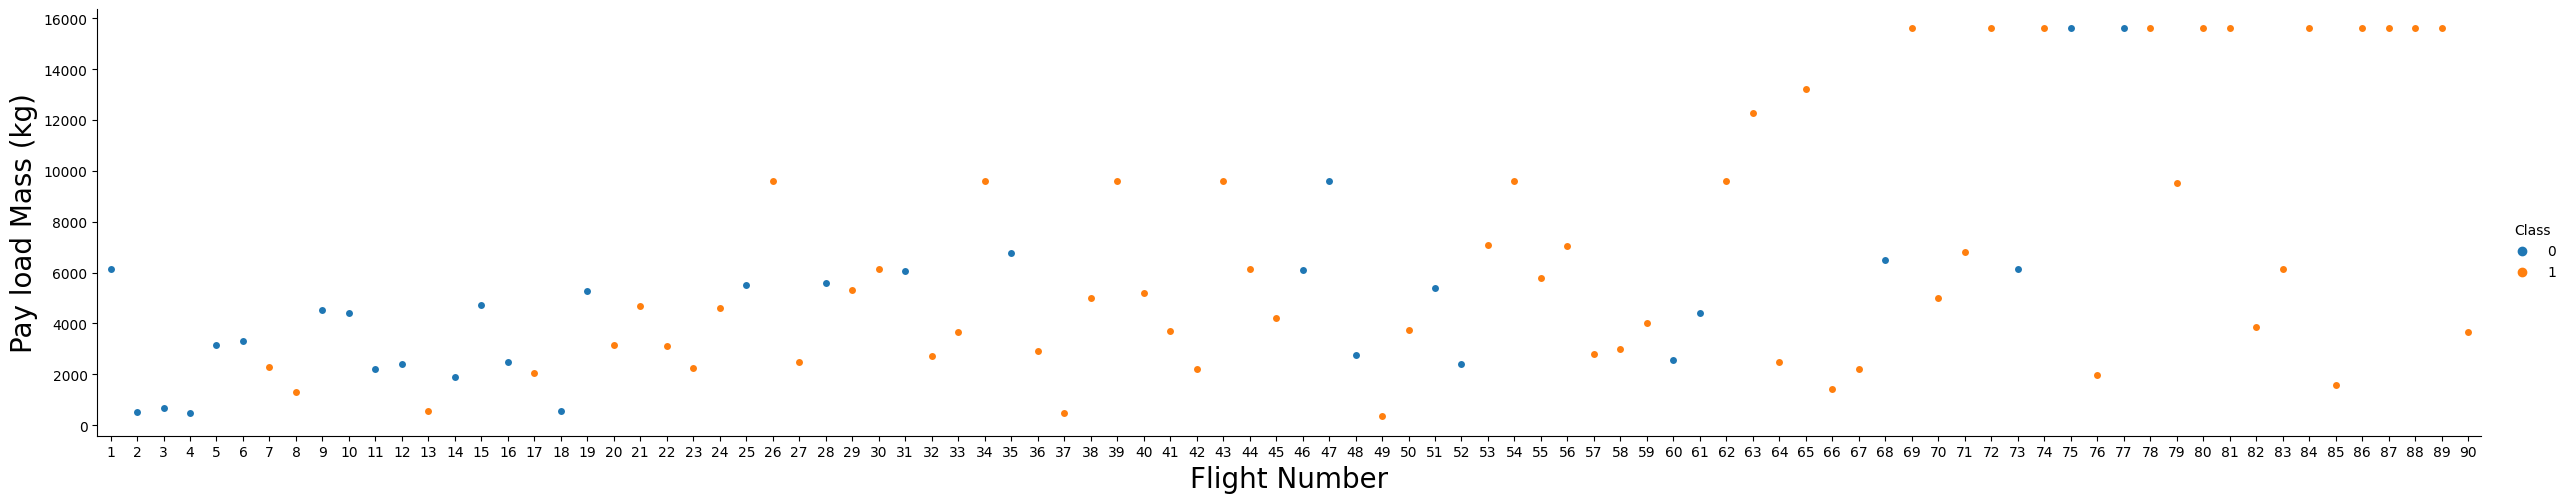

In [ ]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

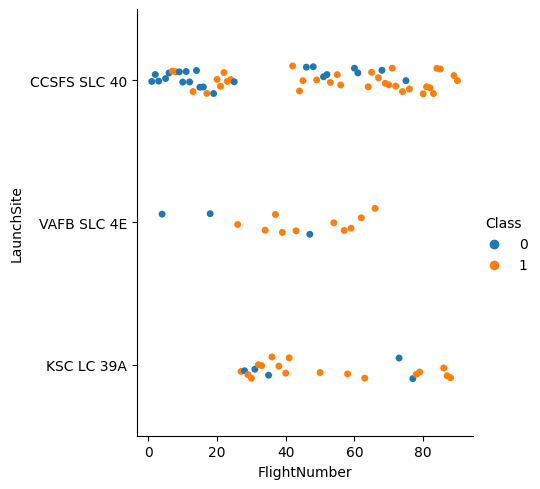

In [ ]:
### TASK 1: Visualize the relationship between Flight Number and Launch Site
sns.catplot(x='FlightNumber', y='LaunchSite', data=df , hue = 'Class')
plt.show()

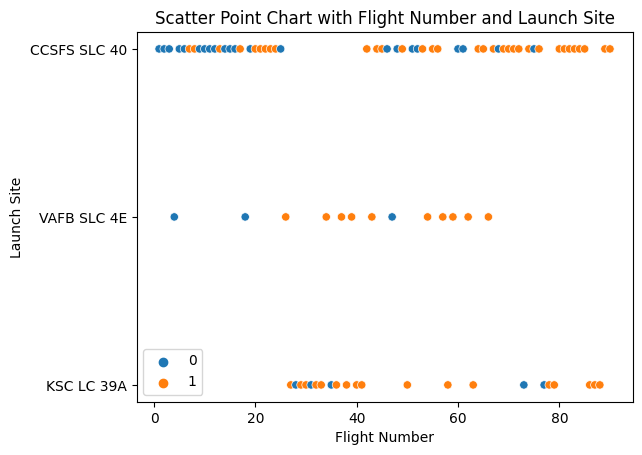

In [ ]:
sns.scatterplot(x='FlightNumber', y='LaunchSite', hue='Class', data=df)

# Customize labels and title
plt.xlabel('Flight Number')
plt.ylabel('Launch Site')
plt.title('Scatter Point Chart with Flight Number and Launch Site')

# Show the legend
plt.legend()

# Show the plot
plt.show()

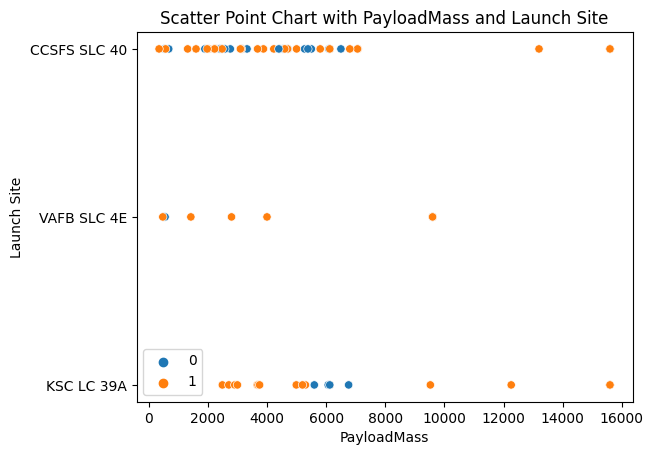

In [ ]:
sns.scatterplot(x='PayloadMass', y='LaunchSite', hue='Class', data=df)

# Customize labels and title
plt.xlabel('PayloadMass')
plt.ylabel('Launch Site')
plt.title('Scatter Point Chart with PayloadMass and Launch Site')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
df2 = pd.DataFrame(df.groupby('Orbit')['Class'].mean())
df2.reset_index(inplace=True)

,Orbit,Class
0,ES-L1,1.000000
1,GEO,1.000000
2,GTO,0.518519
3,HEO,1.000000
4,ISS,0.619048
5,LEO,0.714286
6,MEO,0.666667
7,PO,0.666667
8,SO,0.000000
9,SSO,1.000000


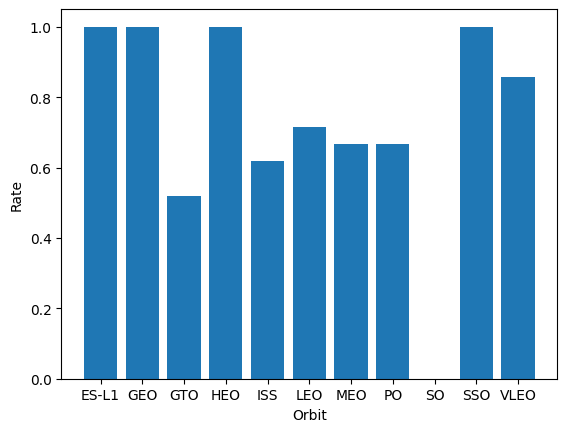

In [ ]:
plt.bar(df2['Orbit'], df2['Class'])

# Add labels and title
plt.xlabel('Orbit')
plt.ylabel('Rate')

# Show the chart
plt.show()

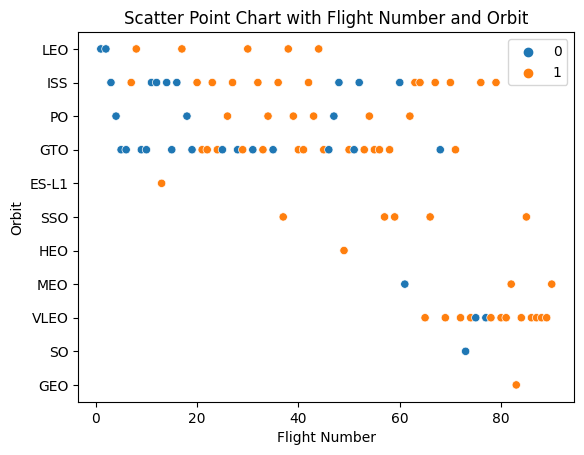

In [ ]:
sns.scatterplot(x='FlightNumber', y='Orbit', hue='Class', data=df)

# Customize labels and title
plt.xlabel('Flight Number')
plt.ylabel('Orbit')
plt.title('Scatter Point Chart with Flight Number and Orbit')

# Show the legend
plt.legend()

# Show the plot
plt.show()

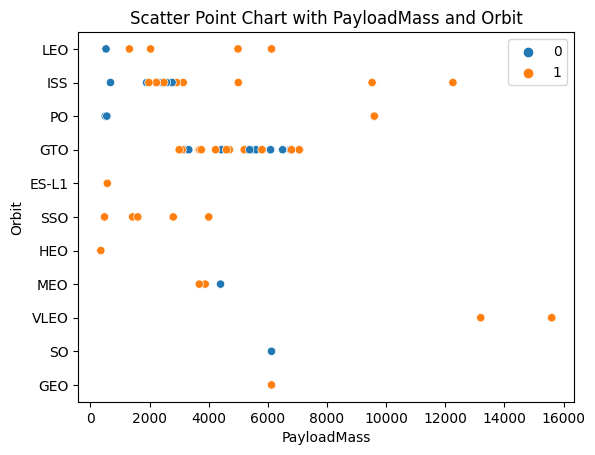

In [ ]:
sns.scatterplot(x='PayloadMass', y='Orbit', hue='Class', data=df)

# Customize labels and title
plt.xlabel('PayloadMass')
plt.ylabel('Orbit')
plt.title('Scatter Point Chart with PayloadMass and Orbit')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
year=[]
def Extract_year():
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year
Extract_year()
df['Date'] = year
df.head()


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [ ]:
df3 = pd.DataFrame(df.groupby('Date')['Class'].mean())
df3.reset_index(inplace=True)
df3

,Date,Class
0,2010,0.000000
1,2012,0.000000
2,2013,0.000000
3,2014,0.333333
4,2015,0.333333
5,2016,0.625000
6,2017,0.833333
7,2018,0.611111
8,2019,0.900000
9,2020,0.842105


Text(0, 0.5, 'Rate')

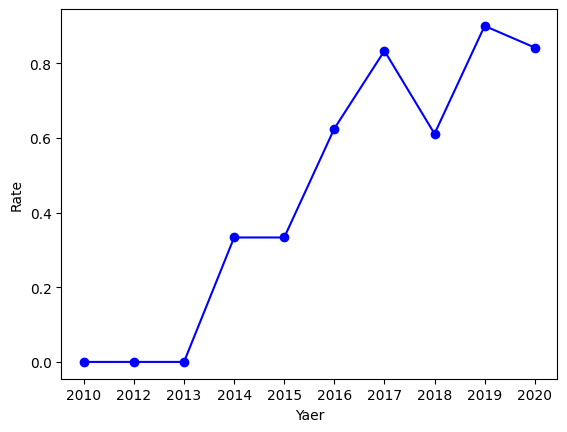

In [ ]:
plt.plot(df3['Date'], df3['Class'], marker='o', linestyle='-', color='b', label='Line Chart')

# Add labels and title
plt.xlabel('Yaer')
plt.ylabel('Rate')


In [ ]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


In [ ]:
features_one_hot = pd.get_dummies(features, columns=["Orbit","LaunchSite","LandingPad","Serial"])
features_one_hot = features_one_hot.astype(float)
features_one_hot.dtypes

FlightNumber    float64
PayloadMass     float64
Flights         float64
GridFins        float64
Reused          float64
                 ...   
Serial_B1056    float64
Serial_B1058    float64
Serial_B1059    float64
Serial_B1060    float64
Serial_B1062    float64
Length: 80, dtype: object

In [ ]:
features_one_hot.shape

(90, 80)

In [ ]:
features_one_hot.to_csv('dataset_part_3.csv', index=False)

## Launch Sites Locations Analysis with Folium

In [ ]:
import folium
import pandas as pd
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

In [ ]:
#Read the `spacex_launch_geo.csv`
spacex_df=pd.read_csv("/content/spacex_launch_geo.csv")

In [ ]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


In [ ]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

In [ ]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

In [ ]:
ls = 0
namels = "CCAFS LC-40"
new_location = folium.Marker(location=list(launch_sites_df.loc[ls,["Lat","Long"]]), zoom_start=10)
circle = folium.Circle(list(launch_sites_df.loc[ls,["Lat","Long"]]), radius=1000, color='#d35400', fill=True).add_child(folium.Popup(namels))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    list(launch_sites_df.loc[ls,["Lat","Long"]]),
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % namels ,
        )
    )
new_location.add_to(site_map)
site_map.add_child(circle)
site_map.add_child(marker)


ls = 1
namels = "CCAFS SLC-40"
new_location = folium.Marker(location=list(launch_sites_df.loc[ls,["Lat","Long"]]), zoom_start=10)
circle = folium.Circle(list(launch_sites_df.loc[ls,["Lat","Long"]]), radius=1000, color='#d35400', fill=True).add_child(folium.Popup(namels))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    list(launch_sites_df.loc[ls,["Lat","Long"]]),
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % namels ,
        )
    )
new_location.add_to(site_map)
site_map.add_child(circle)
site_map.add_child(marker)

ls = 2
namels = "KSC LC-39A"
new_location = folium.Marker(location=list(launch_sites_df.loc[ls,["Lat","Long"]]), zoom_start=10)
circle = folium.Circle(list(launch_sites_df.loc[ls,["Lat","Long"]]), radius=1000, color='#d35400', fill=True).add_child(folium.Popup(namels))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    list(launch_sites_df.loc[ls,["Lat","Long"]]),
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % namels ,
        )
    )
new_location.add_to(site_map)
site_map.add_child(circle)
site_map.add_child(marker)

ls = 3
namels = "VAFB SLC-4E"
new_location = folium.Marker(location=list(launch_sites_df.loc[ls,["Lat","Long"]]), zoom_start=10)
circle = folium.Circle(list(launch_sites_df.loc[ls,["Lat","Long"]]), radius=1000, color='#d35400', fill=True).add_child(folium.Popup(namels))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    list(launch_sites_df.loc[ls,["Lat","Long"]]),
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % namels ,
        )
    )
new_location.add_to(site_map)
site_map.add_child(circle)
site_map.add_child(marker)



In [ ]:
spacex_df.tail(10)

,Launch Site,Lat,Long,class
46,KSC LC-39A,28.573255,-80.646895,1
47,KSC LC-39A,28.573255,-80.646895,1
48,KSC LC-39A,28.573255,-80.646895,1
49,CCAFS SLC-40,28.563197,-80.576820,1
50,CCAFS SLC-40,28.563197,-80.576820,1
51,CCAFS SLC-40,28.563197,-80.576820,0
52,CCAFS SLC-40,28.563197,-80.576820,0
53,CCAFS SLC-40,28.563197,-80.576820,0
54,CCAFS SLC-40,28.563197,-80.576820,1
55,CCAFS SLC-40,28.563197,-80.576820,0


In [ ]:
marker_cluster = MarkerCluster()

In [ ]:
def color_mapper(value):
    if value == 1:
        return "green"
    elif value == 0:
        return "red"


# Use the apply() method to create a new column based on the mapping function
spacex_df['marker_color'] = spacex_df['class'].apply(color_mapper)
spacex_df.head(20)


In [ ]:
# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# for each row in spacex_df data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed,
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, record in spacex_df.iterrows():
    # TODO: Create and add a Marker cluster to the site map
    marker = folium.map.Marker(
    list(spacex_df.loc[index,["Lat","Long"]]) ,
    # Create an icon as a text label

    icon=folium.Icon(color='white', icon_color=spacex_df.loc[index,["marker_color"]][0])

    )

    marker_cluster.add_child(marker)

site_map

In [ ]:
#Calculate the distances between a launch site to its proximities

# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

In [ ]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [ ]:
# find coordinate of the closet coastline
distance_coastline = calculate_distance(28.573255,	-80.646895, 28.5737, -80.6068)
distance_coastline

3.916894050865433

In [ ]:
distance_marker = folium.Marker(
   [28.5737, -80.6068],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline),
        )
    )
site_map.add_child(distance_marker)

In [ ]:
coordinates = [[28.573255,	-80.646895], [28.5737, -80.6068]]
lines=folium.PolyLine(locations=coordinates, weight=1)
site_map.add_child(lines)

##Dashboard application with Plotly dash

In [ ]:
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

spacex_df = pd.read_csv("/Users/romanmartinez/Desktop/SQL Module/spacex_launch_dash.csv")



#Create app
app = dash.Dash(__name__)

app.layout = html.Div(children=[
    html.H1('SpaceX Launch Records Dashboard',
            style={'textAlign': 'center', 'color': '#503D36', 'font-size': 30}),

    html.Div([
        html.Div([
            html.H2('Select Site', style={'margin-right': '2em'}),
             dcc.Dropdown(id='site-dropdown',
                options=[
                    {'label': 'All Sites', 'value': 'ALL'},
                    {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                    {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'},
                    {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'},
                    {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'},
                ],
                value='ALL',
                placeholder="All Sites",
                searchable=True
                ),
        ])
    ]),

    html.Div(dcc.Graph(id='success-pie-chart', style={'display': 'flex'})),

    html.Div([html.H2('Payload range (KG):', style={'margin-right': '2em'}),
    dcc.RangeSlider(id='payload-slider',
                min=0, max=10000, step=1000,
                marks={0: '0',
                       2500: '2500',
                       5000: '5000',
                       7500: '7500',
                       10000: '10000'},
                value=[0, 5000]) ]),

    html.Div(dcc.Graph(id='success-payload-scatter-chart', style={'display': 'flex'})),
])

# Function decorator to specify function input and output
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))

def get_pie_chart(entered_site):
    if entered_site == 'ALL':
        allspx = pd.DataFrame(spacex_df.groupby('Launch Site')['class'].sum())
        allspx.reset_index(inplace=True)
        allspx['Success'] = allspx['class']/spacex_df['class'].sum()

        fig = px.pie(allspx, values='Success',
        names= allspx['Launch Site'] ,
        title='Total Success Launches By Site')
        return fig
    else:
        sub = spacex_df[spacex_df['Launch Site'] == entered_site]["class"]
        sub2 = pd.DataFrame({'Perc': [1-sub.sum()/sub.shape[0],sub.sum()/sub.shape[0]],'Class':[0,1]})
        fig = px.pie(sub2, values='Perc',
        names= sub2['Class'] ,
        title='Total Success Launches for site ' + entered_site)
        return fig


@app.callback(Output(component_id='success-payload-scatter-chart', component_property='figure'),
              [Input(component_id='site-dropdown', component_property='value'),
               Input(component_id="payload-slider", component_property="value")])

def get_scatterplot(entered_site,payload_mass):
    if entered_site == 'ALL':
        filtered_df = spacex_df[(spacex_df['Payload Mass (kg)'] >= payload_mass[0]) & (spacex_df['Payload Mass (kg)'] <= payload_mass[1])]
        fig = px.scatter(filtered_df, x='Payload Mass (kg)', y='class',color='Booster Version Category', title='Correlation between Payload and Success for all Sites')
        return fig
    else:
        filter1 = spacex_df[spacex_df['Launch Site'] == entered_site]
        filtered_df = filter1[(filter1['Payload Mass (kg)'] >= payload_mass[0]) & (filter1['Payload Mass (kg)'] <= payload_mass[1])]
        fig = px.scatter(filtered_df, x='Payload Mass (kg)', y='class',color='Booster Version Category', title='Correlation between Payload and Success for ' + entered_site, )
        return fig



if __name__ == '__main__':
    app.run_server(port=8081)


##Machine Learning Prediction

In [ ]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

In [ ]:
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
data = pd.read_csv(URL1)
data.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [ ]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
X = pd.read_csv(URL2)
X.head(5)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
Y = data["Class"].to_numpy()

In [23]:
#Standardize data
X = preprocessing.StandardScaler().fit(X).transform(X)

In [72]:
#Train and test data
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=2)

In [68]:
X_test.shape



(18, 83)

In [73]:
y_test.shape

(18,)

In [41]:
#Create a logistic regression

parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

logreg_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=10)

logreg_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)




tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


In [42]:
#Evaluation
yhat = logreg_cv.predict(X_test)

from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=0)

0.5

In [79]:
logreg_cv.score(X_test,y_test)

0.8333333333333334

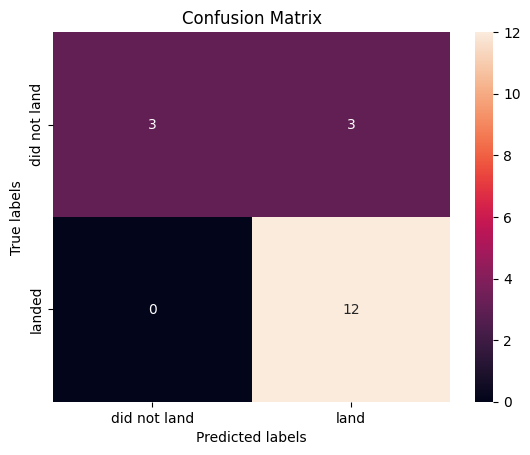

In [44]:
plot_confusion_matrix(y_test,yhat)

In [46]:
#SVM

parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

svm_cv = GridSearchCV(estimator=svm, param_grid=parameters, cv=10)

svm_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


In [58]:
#Evaluation

yhat = svm_cv.predict(X_test)

from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat)

0.8

In [76]:
svm_cv.score(X_test,y_test)

0.8333333333333334

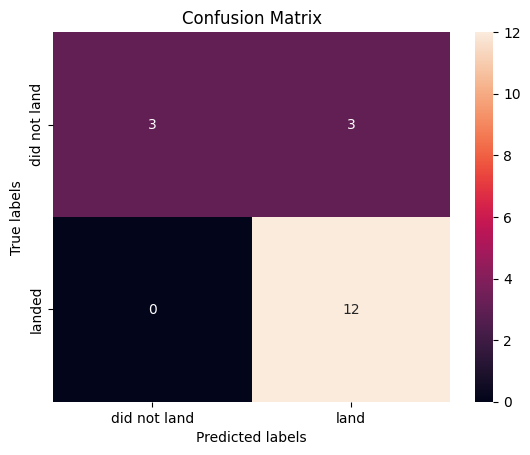

In [56]:
plot_confusion_matrix(y_test,yhat)

In [ ]:
#Tree classifiers

parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

tree_cv = GridSearchCV(estimator=tree, param_grid=parameters, cv=10)

tree_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

In [60]:
yhat = tree_cv.predict(X_test)

from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat)

0.5333333333333333

In [81]:
tree_cv.score(X_test,y_test)

0.6111111111111112

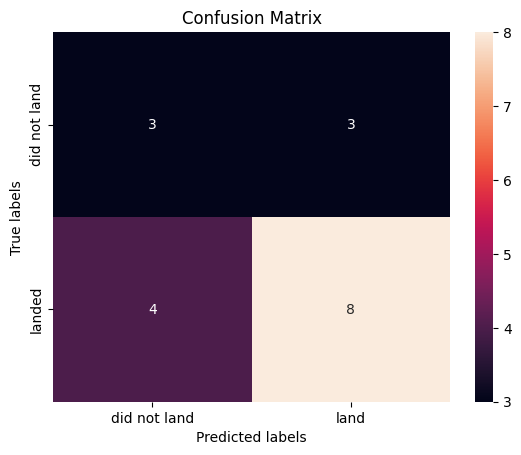

In [62]:
plot_confusion_matrix(y_test,yhat)

In [63]:
#K nearest neighbours

parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

knn_cv = GridSearchCV(estimator=KNN, param_grid=parameters, cv=10)

knn_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


In [64]:
yhat = knn_cv.predict(X_test)

from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat)

0.8

In [75]:
knn_cv.score(X_test,y_test)

0.8333333333333334

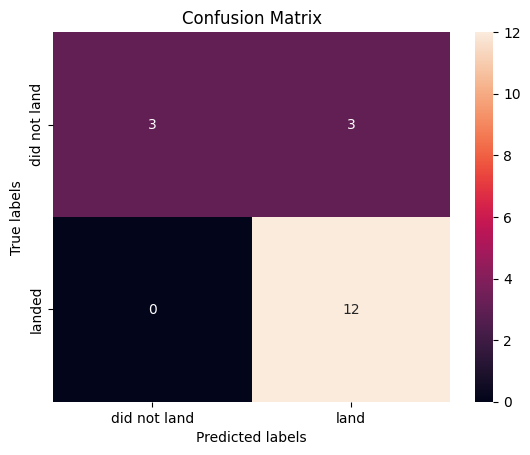

In [66]:
plot_confusion_matrix(y_test,yhat)